In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import argparse
from ddpg_torch.ddpg_torch import Agent
import gym
import numpy as np
from lifting_rl.linkage_env import LinkageEnv

from livelossplot import PlotLosses

In [2]:
params = {
    "N_LINKS": 5,
    "PARAM_VALS": np.array([9.81], dtype=np.float32),
    "OBS_LOW": np.array([0.5, 1, -0.5, -2.5, -2], dtype=np.float32),
    "OBS_HIGH": np.array([2.5, 3.1, 2.2, -0.3, -0.2], dtype=np.float32),
    "SPEED_LIMIT": 8,
    "ACT_LIMIT": 1000,
    "TIME_STEP": 0.01,
    "VIDEO_FPS": 30,
}


In [3]:
env = LinkageEnv(params, verbose=0)

observation_space:  Box(10,)
action_space:  Box(5,)


In [4]:
agent = Agent(
    lr_actor=0.000025,
    lr_critic=0.00025,
    input_dims=[25],
    tau=0.001,
    env=env,
    batch_size=64,
    layer1_size=400,
    layer2_size=300,
    n_actions=5,
    chkpt_dir="/home/mans/Documents/ddpg/6"
)

In [5]:
np.random.seed(0)

In [6]:
liveloss = PlotLosses()

In [7]:
score_history = []

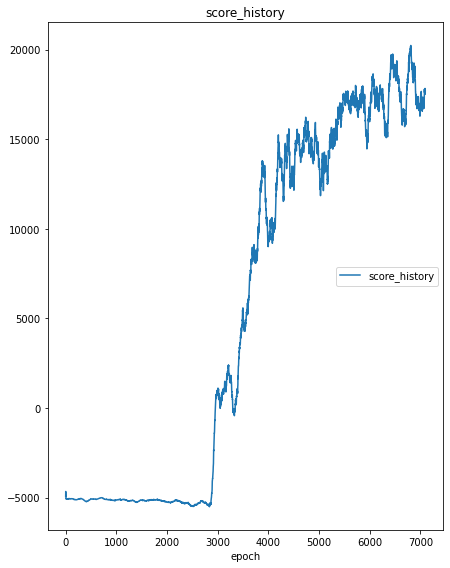

score_history
	score_history    	 (min: -5508.566, max: 20234.147, cur: 17678.317)
episode 7098 score 15230.14 100 game average 17678.32


In [ ]:
for i in range(100000):
    done = False
    score = 0
    obs = env.reset()
    agent.noise.reset()
    while not done:
        env.render()
        act = agent.choose_action(obs)
        new_state, reward, done, info = env.step(act)
        agent.remember(obs, act, reward, new_state, int(done))
        agent.learn()
        score += reward
        obs = new_state

    score_history.append(score)
    metrics = {"score_history": np.mean(score_history[-100:])}
    liveloss.update(metrics)
    liveloss.send()
    print(
        "episode",
        i,
        "score %.2f" % score,
        "100 game average %.2f" % np.mean(score_history[-100:]),
    )
    
    if i % 500 == 0:
        agent.save_models()
env.close()

    